## Predicting Dengue


### Load Data and wrangle Data
> Load the data and import libraries fill na values and create new variable mean_vegetaiton_index

In [944]:
# Classic Python data science Starter pack

from pandas import DataFrame
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf # linear modeling
from sklearn.model_selection import train_test_split # Split into train test data

features = pd.read_csv('data/dengue_features_train.csv')
labels = pd.read_csv('data/dengue_labels_train.csv')


In [945]:
# Merge Train features and labels into one table
# result = pd.merge(train_features, train_labels, on=['weekofyear','year', 'city'])

# Drop Extra features
# features = features.drop(columns=[ 'station_max_temp_c','station_precip_mm', 'station_diur_temp_rng_c', 'precipitation_amt_mm'])

# Fill missing values with ffill
features.fillna(method='ffill', inplace=True)
labels.fillna(method='ffill', inplace=True)

### Add columns and split data by city
##### 0 - Iquitos
##### 1 - San Juan

In [946]:
# add column lag cases
def add_lag_cases(a, n):
    a= a.copy()
    
    # set columnm name
    name =  "lag_cases_" + str(n)
    
    #save first n values of total case
    last_n = []
    for i in range(len(a) - n,len(a)):
        last_n.append(a.iloc[i, a.columns.get_loc('total_cases')] )
        
    last_val = sum(last_n)/len(last_n)
    # shift columns  
    a[name] = a.total_cases.shift(-n)

    # add last values
    for i in range(len(a) - n,len(a)):
        a[name][i] = last_val
    return a


def subset_by_city(city, df):
    return df[df.city == city]



Prepare data for final training (only features)

In [965]:
more_features = pd.read_csv('data/dengue_features_test.csv')
more_features.fillna(method='ffill', inplace=True)
final_features_by_city = [subset_by_city(c, more_features).copy().reset_index(drop=True) for c in ['iq','sj']]

final_features_by_city[0]['mean_vegetation_index'] = (final_features_by_city[0]['ndvi_se'] + final_features_by_city[0]['ndvi_sw'] + final_features_by_city[0]['ndvi_ne'] + final_features_by_city[0]['ndvi_nw']) / 4
final_features_by_city[1]['mean_vegetation_index'] = (final_features_by_city[1]['ndvi_se'] + final_features_by_city[1]['ndvi_sw'] + final_features_by_city[1]['ndvi_ne'] + final_features_by_city[1]['ndvi_nw']) / 4

final_features_by_city[0] = final_features_by_city[0].drop(columns=['ndvi_ne', 'ndvi_nw', 'ndvi_se','ndvi_sw'])
final_features_by_city[1] = final_features_by_city[1].drop(columns=['ndvi_ne', 'ndvi_nw', 'ndvi_se','ndvi_sw'])


Prepare data for train and testing

In [966]:
# subsets data by CITY 
features_by_city = [subset_by_city(c, features).copy().reset_index(drop=True) for c in ['iq','sj']]
labels_by_city = [subset_by_city(c, labels).copy().reset_index(drop=True) for c in ['iq','sj']]


# add lag cases to labels
# add 4 weeks lag
labels_by_city[0] = add_lag_cases(labels_by_city[0], 4)
labels_by_city[1] = add_lag_cases(labels_by_city[1], 4)

# add 8 weeks lag
labels_by_city[0] = add_lag_cases(labels_by_city[0], 8)
labels_by_city[1] = add_lag_cases(labels_by_city[1], 8)

# add 12 weeks lag
labels_by_city[0] = add_lag_cases(labels_by_city[0], 12)
labels_by_city[1] = add_lag_cases(labels_by_city[1], 12)


# add mean vegetation index column
features_by_city[0]['mean_vegetation_index'] = (features_by_city[0]['ndvi_se'] + features_by_city[0]['ndvi_sw'] + features_by_city[0]['ndvi_ne'] + features_by_city[0]['ndvi_nw']) / 4
features_by_city[1]['mean_vegetation_index'] = (features_by_city[1]['ndvi_se'] + features_by_city[1]['ndvi_sw'] + features_by_city[1]['ndvi_ne'] + features_by_city[1]['ndvi_nw']) / 4

# Drop vegetation columns
features_by_city[0] = features_by_city[0].drop(columns=['ndvi_ne', 'ndvi_nw', 'ndvi_se','ndvi_sw'])
features_by_city[1] = features_by_city[1].drop(columns=['ndvi_ne', 'ndvi_nw', 'ndvi_se','ndvi_sw'])


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Feature Selection
> Selecting top 5 features using Recursive Feature Elimination. RFE works by recursively removing attributes and building a model on attributes that remain.

In [967]:
from sklearn.feature_selection import SelectKBest, chi2, RFE
from itertools import compress
features_by_city[0] = features_by_city[0].drop(columns=[ 'year','city', 'week_start_date'])
features_by_city[1] = features_by_city[1].drop(columns=[ 'year','city', 'week_start_date'])

final_features_by_city[0] = final_features_by_city[0].drop(columns=[ 'year','city', 'week_start_date'])
final_features_by_city[1] = final_features_by_city[1].drop(columns=[ 'year','city', 'week_start_date'])

model = GradientBoostingRegressor()
rfe = RFE(model, 6)
best_feature_names = [None, None]

for i in [0,1]:
    best_features[i] = pd.DataFrame(rfe.fit_transform(features_by_city[i], labels_by_city[i].total_cases))
    best_feature_names[i] = list(compress(final_features_by_city[i].columns.values, rfe.get_support()))


# best_features = [pd.DataFrame(rfe.fit_transform(features_by_city[i], labels_by_city[i].total_cases)) for i in [0,1]]




In [968]:
# best_features[1]
best_feature_names[0]

['weekofyear',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_specific_humidity_g_per_kg',
 'mean_vegetation_index']

In [969]:
best_feature_names[1]

['weekofyear',
 'reanalysis_air_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_specific_humidity_g_per_kg',
 'station_avg_temp_c',
 'mean_vegetation_index']

In [952]:
# These formulas are not used since we are programmatically picking features above ^^^^^^
# f0 = ['reanalysis_specific_humidity_g_per_kg', 
#                  'reanalysis_dew_point_temp_k', 
#                  'station_min_temp_c',
#                  'reanalysis_min_air_temp_k']

# f1 = ['reanalysis_specific_humidity_g_per_kg', 
#                  'reanalysis_dew_point_temp_k', 
#                  'station_avg_temp_c', 
#                  'mean_vegetation_index',
#                  'reanalysis_max_air_temp_k']

# features_by_city[0] = features_by_city[0][f0]
# features_by_city[1] = features_by_city[1][f1]


# Add best features to our training features
features_by_city[0] = best_features[0]
features_by_city[1] = best_features[1]

final_features_by_city[0] = final_features_by_city[0][best_feature_names[0]]
final_features_by_city[1] = final_features_by_city[1][best_feature_names[1]]

In [955]:
labels_by_city[0]

,city,year,weekofyear,total_cases,lag_cases_4,lag_cases_8,lag_cases_12
0,iq,2000,26,0,0.0,0.00,0.000000
1,iq,2000,27,0,0.0,0.00,0.000000
2,iq,2000,28,0,0.0,1.00,0.000000
3,iq,2000,29,0,0.0,0.00,1.000000
4,iq,2000,30,0,0.0,0.00,1.000000
5,iq,2000,31,0,0.0,0.00,0.000000
6,iq,2000,32,0,1.0,0.00,0.000000
7,iq,2000,33,0,0.0,1.00,0.000000
8,iq,2000,34,0,0.0,1.00,0.000000
9,iq,2000,35,0,0.0,0.00,0.000000


### Split Test, Train data for each city


In [970]:
# Iquitos
I_train_features, I_test_features, I_train_outcome, I_test_outcome = train_test_split(
    features_by_city[0],
    labels_by_city[0],
    test_size = 0.25,
    random_state = 11
)

In [971]:
# San Juan
sj_train_features, sj_test_features, sj_train_outcome, sj_test_outcome = train_test_split(
    features_by_city[1],
    labels_by_city[1],
    test_size = 0.25,
    random_state = 11
)

## Implementing Models

In [796]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler       # scaling data
from sklearn.neighbors import KNeighborsRegressor    # regressor
from sklearn.model_selection import GridSearchCV     # for grid search
from sklearn.pipeline import make_pipeline  
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures()# for making pipelines
scaler = MinMaxScaler()
knn_reg = KNeighborsRegressor()
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression()
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import RidgeCV


In [866]:
# Tracking scores from models
mae_scores = pd.DataFrame(columns=["Model", "Iquitos", "San_Juan"])
mae_scores["Model"] = ['KNN_Regressor', "RidgeCV_Regressor", "Random_Forest_Regressor", "Gradient_Boosting_Regressor", "Bagging Regressor"]
mae_scores
iq = []
sj = []



### KNN Regressor

In [867]:
# Define a pipeline that includes the polynomial transformation
pipe = make_pipeline(poly, scaler, knn_reg)

# Define a grid to search through (including the degree of polynomial)
param_grid = {'polynomialfeatures__degree':range(1, 3), 
              'kneighborsregressor__n_neighbors':range(1, 4), 
              'kneighborsregressor__weights':["uniform", "distance"]}

# Perform a  grid search of your pipeline
grid = GridSearchCV(pipe, param_grid, scoring="neg_mean_absolute_error")

grid.fit(I_train_features, I_train_outcome.total_cases)
print(grid.score(I_test_features, I_test_outcome.total_cases))
print(grid.best_params_)
iq.append(grid.score(I_test_features, I_test_outcome.total_cases))


grid.fit(sj_train_features, sj_train_outcome.total_cases)
print(grid.score(sj_test_features, sj_test_outcome.total_cases))
print(grid.best_params_)
sj.append(grid.score(sj_test_features, sj_test_outcome.total_cases))


-6.86752136752
{'kneighborsregressor__n_neighbors': 3, 'kneighborsregressor__weights': 'uniform', 'polynomialfeatures__degree': 1}
-24.2402023399
{'kneighborsregressor__n_neighbors': 3, 'kneighborsregressor__weights': 'distance', 'polynomialfeatures__degree': 2}


### RidgeCV Regressor

In [956]:
ridge = RidgeCV()


# Define a pipeline that includes the polynomial transformation
pipe = make_pipeline(poly, scaler, RidgeCV())

# Define a grid to search through (including the degree of polynomial)
param_grid = {'polynomialfeatures__degree':range(1, 4) }

# Perform a  grid search of your pipeline
grid = GridSearchCV(pipe, param_grid, scoring="neg_mean_absolute_error")

# grid.fit(I_train_features, I_train_outcome.total_cases)
grid.fit(features_by_city[0], labels_by_city[0].total_cases)
# print(grid.score(I_test_features, I_test_outcome.total_cases))
print(grid.best_params_)
# a = grid.predict(final_features_by_city[0][f0]).astype(int)
iq.append(grid.score(I_test_features, I_test_outcome.total_cases))



# grid.fit(sj_train_features, sj_train_outcome.total_cases)
grid.fit(features_by_city[1], labels_by_city[1].total_cases)
# print(grid.score(sj_test_features, sj_test_outcome.total_cases))
print(grid.best_params_)
#b = grid.predict(final_features_by_city[1][f1]).astype(int)
sj.append(grid.score(sj_test_features, sj_test_outcome.total_cases))



{'polynomialfeatures__degree': 1}
{'polynomialfeatures__degree': 3}


### Random Forest Regressor

In [869]:
from sklearn.ensemble import RandomForestRegressor
random_forest = RandomForestRegressor()

In [ ]:


# Define a pipeline that includes the polynomial transformation
pipe = make_pipeline(poly, scaler, random_forest)

# Define a grid to search through (including the degree of polynomial)
param_grid = {'polynomialfeatures__degree':[1,2,3,4],
             'randomforestregressor__bootstrap': [True],
             'randomforestregressor__max_depth': [10],
             'randomforestregressor__max_features': ['auto', 'sqrt'],
             'randomforestregressor__min_samples_leaf': [4],
             'randomforestregressor__min_samples_split': [ 10],
             'randomforestregressor__n_estimators': [ 600,1200, 1400]}

# Perform a  grid search of your pipeline
grid = GridSearchCV(pipe, param_grid, scoring="neg_mean_absolute_error")

grid.fit(I_train_features, I_train_outcome.total_cases)
# grid.fit(features_by_city[0], labels_by_city[0].total_cases)
print(grid.score(I_test_features, I_test_outcome.total_cases))
print(grid.best_params_)
# iq.append(grid.score(I_test_features, I_test_outcome.total_cases))
# a = grid.predict(final_features_by_city[0]).astype(int)


grid.fit(sj_train_features, sj_train_outcome.total_cases)
# grid.fit(features_by_city[1], labels_by_city[1].total_cases)
print(grid.score(sj_test_features, sj_test_outcome.total_cases))
print(grid.best_params_)
# sj.append(grid.score(sj_test_features, sj_test_outcome.total_cases))
# b = grid.predict(final_features_by_city[1]).astype(int)


### Gradient Boosting Regressor

In [934]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Hyper parameter optimization already performed
#learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10
# Define a pipeline that includes the polynomial transformation
pipe = make_pipeline(poly, scaler, GradientBoostingRegressor())

# Define a grid to search through (including the degree of polynomial)
param_grid = {'polynomialfeatures__degree':range(1, 4)
             }

# Perform a  grid search of your pipeline
grid = GridSearchCV(pipe, param_grid, scoring="neg_mean_absolute_error")

grid.fit(I_train_features, I_train_outcome.total_cases)
print(grid.score(I_test_features, I_test_outcome.total_cases))
print(grid.best_params_)
# a = grid.predict(final_features_by_city[0]).astype(int)
iq.append(grid.score(I_test_features, I_test_outcome.total_cases))


grid.fit(sj_train_features, sj_train_outcome.total_cases)
print(grid.score(sj_test_features, sj_test_outcome.total_cases))
print(grid.best_params_)
# b = grid.predict(final_features_by_city[1]).astype(int)
sj.append(grid.score(sj_test_features, sj_test_outcome.total_cases))


-6.18755602962
{'polynomialfeatures__degree': 2}
-22.6801413629
{'polynomialfeatures__degree': 2}


pandas.core.series.Series

### Bagging Regressor 

In [938]:

from sklearn.ensemble import BaggingRegressor

# Define a pipeline that includes the polynomial transformation
pipe = make_pipeline(poly, scaler, BaggingRegressor())

# Define a grid to search through (including the degree of polynomial)
param_grid = {'polynomialfeatures__degree':range(1, 4)
             }

# Perform a  grid search of your pipeline
grid = GridSearchCV(pipe, param_grid, scoring="neg_mean_absolute_error")

grid.fit(I_train_features, I_train_outcome.total_cases)
print(grid.score(I_test_features, I_test_outcome.total_cases))
print(grid.best_params_)
# a = grid.predict(final_features_by_city[0][f0]).astype(int)
iq.append(grid.score(I_test_features, I_test_outcome.total_cases))


grid.fit(sj_train_features, sj_train_outcome.total_cases)
print(grid.score(sj_test_features, sj_test_outcome.total_cases))
print(grid.best_params_)
# b = grid.predict(final_features_by_city[1][f1]).astype(int)
sj.append(grid.score(sj_test_features, sj_test_outcome.total_cases))


-6.85512820513
{'polynomialfeatures__degree': 2}
-22.9879003559
{'polynomialfeatures__degree': 1}


### Visualizing Outcomes

In [873]:
mae_scores.Iquitos = iq
mae_scores.San_Juan = sj 
mae_scores

### Model Comparison

#### Iquitos Results

/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


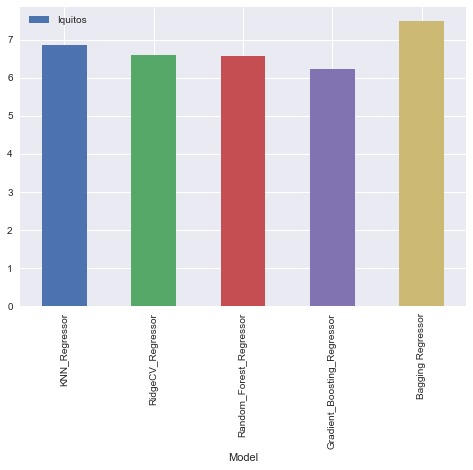

In [875]:
# Bar plot for scores of each model in increasing order of accuracy
# p = sns.barplot(x='Model', y='Iquitos', data=mae_scores)
# p.set_xticklabels(p.get_xticklabels(),rotation=30)
# p.get_figure() 
mae_scores.Iquitos = -mae_scores.Iquitos 
p = mae_scores.plot(x='Model',y= 'Iquitos', kind='bar')
p.get_figure()

#### San Juan Results 

/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


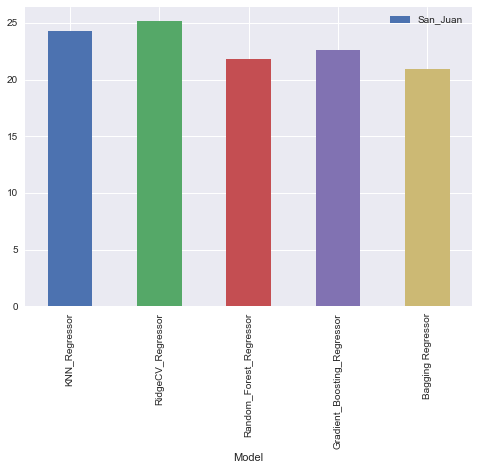

In [876]:
# Bar plot for scores of each model in increasing order of accuracy
mae_scores.San_Juan = -mae_scores.San_Juan
p = mae_scores.plot(x='Model',y= 'San_Juan', kind='bar')
p.get_figure()
# p = sns.barplot(x='Model', y='San_Juan', data=mae_scores)
# p.set_xticklabels(p.get_xticklabels(),rotation=30)
# p.get_figure() 

#### Comparing predictions to data
> Compares predicted and actual data for last run grid

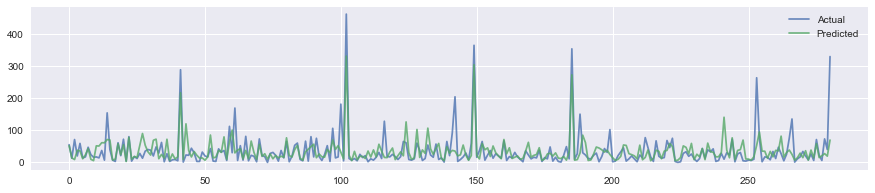

In [939]:
plt.figure(figsize=(15, 3))
sj_test_outcome.total_cases.reset_index(drop=True).plot(label="Actual", alpha = .8, kind='line')
pd.Series(grid.predict(sj_test_features)).plot(label="Predicted", alpha = .8)
plt.legend()
pylab.show()
# print(pd.Series(grid.predict(sj_test_features)))
# print(sj_test_outcome.total_cases.reset_index(drop=True))

## Submission Code

In [961]:

# submissionc code borrowed from benchmark file
submission = pd.read_csv("data/submission_format.csv")
submission.total_cases = np.concatenate([b, a])
submission 

submission.to_csv("data/benchmark_5.csv", index=False)

In [777]:
# submission